# Введение

В современном мире конкуренция в сфере электронной коммерции становится все более острой, и для успешного выживания компании должны постоянно совершенствовать свои методы привлечения и удержания клиентов. Интернет-магазин "В один клик" столкнулся с вызовом снижения активности покупателей, что подчеркивает необходимость разработки инновационных подходов для удержания постоянной клиентуры.

В этом контексте применение машинного обучения представляется как перспективное решение для создания персонализированных предложений. Анализ данных о поведении клиентов и их предпочтениях позволит определить индивидуальные потребности каждого клиента и предложить им наиболее релевантные и привлекательные товары и услуги.

Целью данного проекта является разработка системы машинного обучения, способной адаптировать предложения интернет-магазина "В один клик" к потребностям каждого постоянного клиента. Это позволит не только повысить уровень удовлетворенности клиентов, но и стимулировать их активность в сфере покупок, что в свою очередь приведет к увеличению выручки и повышению конкурентоспособности компании.

**Описание данных**

***market_file.csv***

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

id — номер покупателя в корпоративной базе данных.

Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

Тип сервиса — уровень сервиса, например «премиум» и «стандарт».

Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.

Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.

Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.

Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.

Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.

Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

***market_money.csv***

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.

Выручка — сумма выручки за период.

***market_time.csv***

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

id — номер покупателя в корпоративной базе данных.

Период — название периода, во время которого зафиксировано общее время.

минут — значение времени, проведённого на сайте, в минутах.


***money.csv***

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

id — номер покупателя в корпоративной базе данных.

Прибыль — значение прибыли.

# 1. Загрузка данных

In [1]:
!pip install phik -q

In [2]:
!pip install shap -q # -q убирает необязательные выводы в командах Linux

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.metrics import (
    f1_score, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    classification_report)

In [4]:
#функция для построения графика с усами и гистрограммы
def hist_plot(data):
    # Построение гистограммы
    plt.hist(data, bins=30, lw=1, ec='black', color = 'purple') 
    plt.title('Гистограмма')
    plt.grid(linestyle='dashed')

    # Отображение гистограммы
    plt.show()

    # Построение ящика с усами
    plt.boxplot(data)
    plt.title('Ящик с усами')

    # Отображение ящика с усами
    plt.show()
    print('Описательная статистика')
    print(data.describe())
    print('-'*50)

In [5]:
#функция для построения графиков для категориальных признаков
def cat_plots(data):
    # Подсчет количества вхождений каждой категории
    value_counts = data.value_counts()

    # Построение столбчатой диаграммы
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)  # Создаем первый subplot
    plt.bar(value_counts.index, value_counts.values, color='blue')
    plt.title('Столбчатая диаграмма')
    plt.xlabel('Категория')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)  # Поворот меток по оси x для улучшения читаемости

    # Построение круговой диаграммы
    plt.subplot(1, 2, 2)  # Создаем второй subplot
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Круговая диаграмма')

    # Отображение обеих диаграмм
    plt.tight_layout()  # Автоматическое распределение subplot для улучшения визуализации
    plt.show()

In [6]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


все названия столбцов и данные соответсвуют описанным в market_file

In [7]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


все названия столбцов и данные соответсвуют описанным в market_money

In [8]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


все названия столбцов и данные соответсвуют описанным в market_time

In [9]:
money = pd.read_csv('/datasets/money.csv', sep = ';')
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


все названия столбцов и данные соответсвуют описанным в money

# 2. Предобработка данных

Начнем с таблицы *market_file*

In [10]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

с типами данных все хорошо, пропусков нет, проверим на явные и неявные дубликаты

In [11]:
market_file.duplicated().sum()

0

In [12]:
columns = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
for column in columns:
    print(column, '-', market_file[column].unique())

Покупательская активность - ['Снизилась' 'Прежний уровень']
Тип сервиса - ['премиум' 'стандартт' 'стандарт']
Разрешить сообщать - ['да' 'нет']
Популярная_категория - ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


обнаружили ошибку в колонке тип сервиса: 'стандартт' 'стандарт', заменим значения

In [13]:
market_file['Тип сервиса'].replace('стандартт', 'стандарт', inplace=True)
market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [14]:
market_file.duplicated().sum()

0

После исправления ошибки, новых дубликатов не обнаружено, идем дальше к таблице *market_money*

In [15]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


с типами данных все хорошо, пропусков нет, проверим на явные и неявные дубликаты

In [16]:
market_money.duplicated().sum()

0

In [17]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

дубликатов не обнаружено, идем дальше к таблице *market_time*

In [18]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


с типами данных все хорошо, пропусков нет, проверим на явные и неявные дубликаты

In [19]:
market_time.duplicated().sum()

0

In [20]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

исправим ошибку в 'предыдцщий_месяц'

In [21]:
market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц', inplace = True)
market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

дубликатов не обнаружено, идем дальше к таблице *money*

In [22]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


прибыль надо привести к типу float

In [23]:
money[['Прибыль']] = money[['Прибыль']].replace(',', '.', regex=True).astype(float)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Поменяли тип данных, теперь проверим на дубликаты

In [24]:
money.duplicated().sum()

0

таким образом, предобработка данных завершена

# 3. Исследовательский анализ данных

построим гистограмму и ящик с усами для числовых признаков таблицы *market_file*

Маркет_актив_6_мес


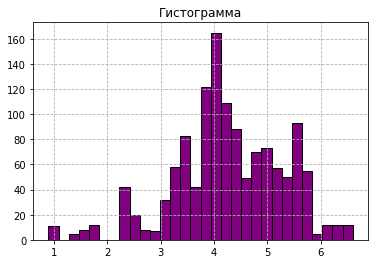

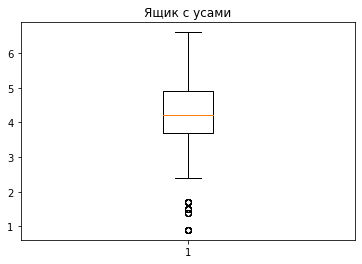

Описательная статистика
count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64
--------------------------------------------------
Маркет_актив_тек_мес


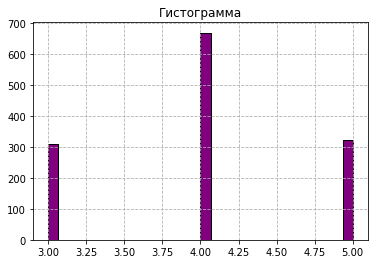

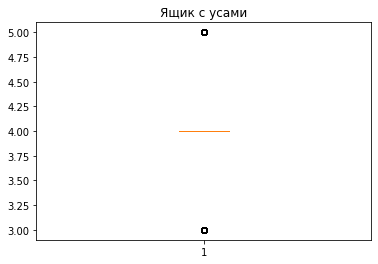

Описательная статистика
count    1300.000000
mean        4.011538
std         0.696868
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Маркет_актив_тек_мес, dtype: float64
--------------------------------------------------
Длительность


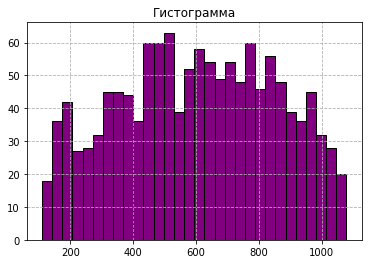

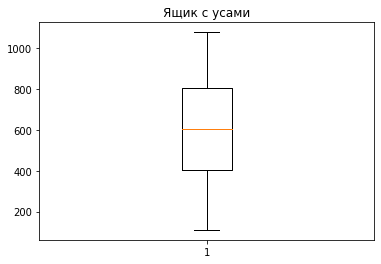

Описательная статистика
count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64
--------------------------------------------------
Акционные_покупки


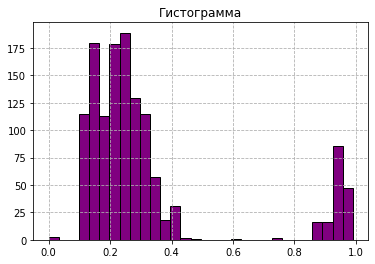

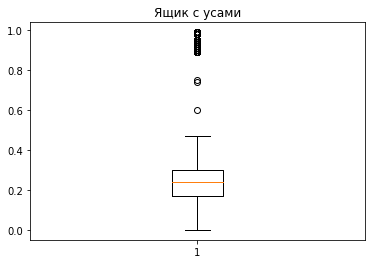

Описательная статистика
count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64
--------------------------------------------------
Средний_просмотр_категорий_за_визит


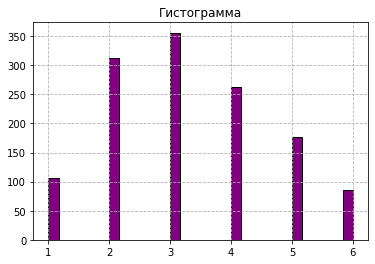

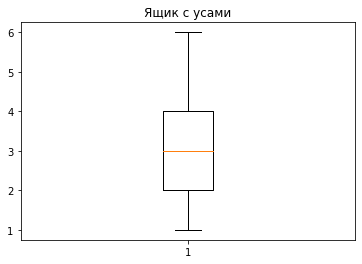

Описательная статистика
count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64
--------------------------------------------------
Неоплаченные_продукты_штук_квартал


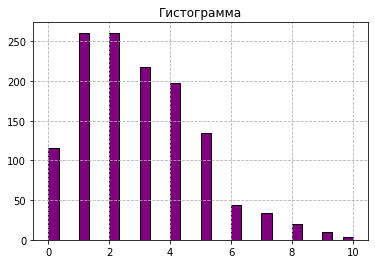

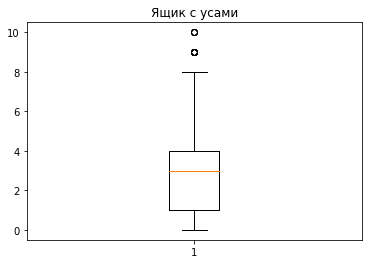

Описательная статистика
count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64
--------------------------------------------------
Ошибка_сервиса


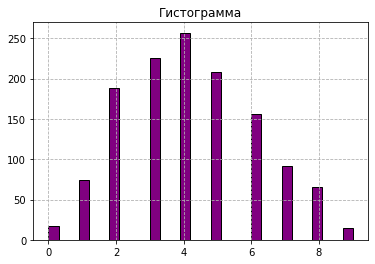

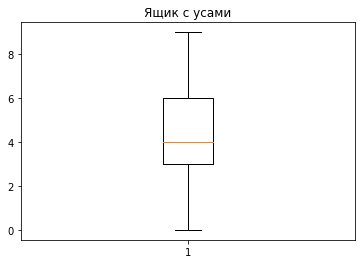

Описательная статистика
count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64
--------------------------------------------------
Страниц_за_визит


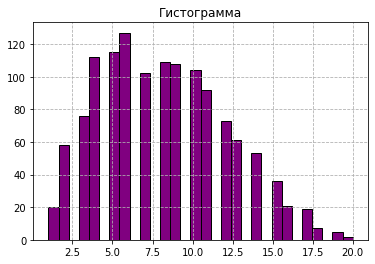

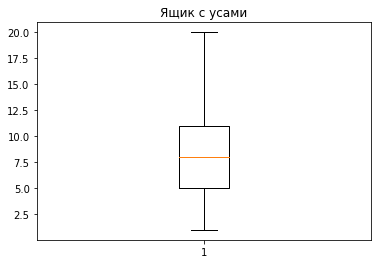

Описательная статистика
count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64
--------------------------------------------------


In [25]:
columns = ['Маркет_актив_6_мес', 
           'Маркет_актив_тек_мес', 
           'Длительность', 
           'Акционные_покупки', 
           'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 
           'Ошибка_сервиса', 
           'Страниц_за_визит']
for column in columns:
    print(column)
    hist_plot(market_file[column])

столбец маркет_актив_тек_мес имеет мультимодальное распределение с пиками: 3, 4, 5

столбец акционные_покупки имеет бимодальное распределение, на гистограмме мы можем наблюдать 2 пика

Рассмотрим теперь графики для категориальных признаков

Покупательская активность


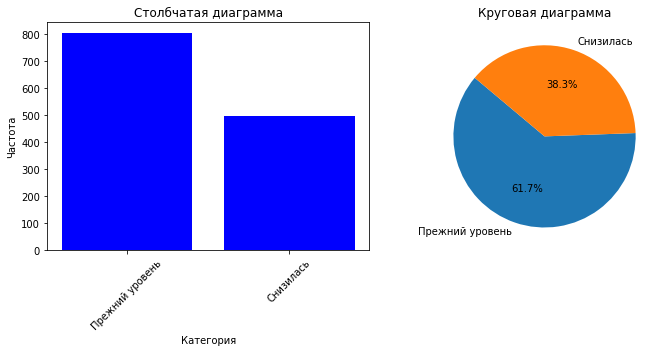

----------------------------------------------------------------------------------------------------
Тип сервиса


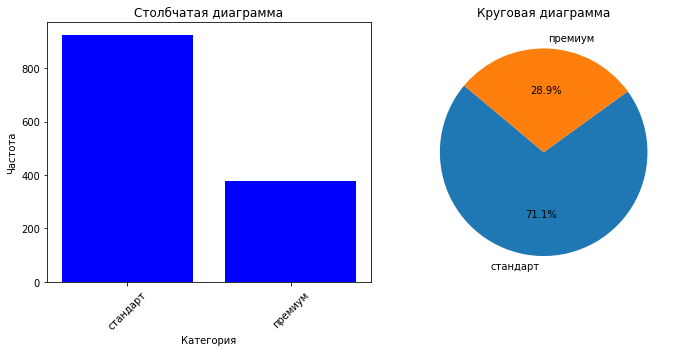

----------------------------------------------------------------------------------------------------
Разрешить сообщать


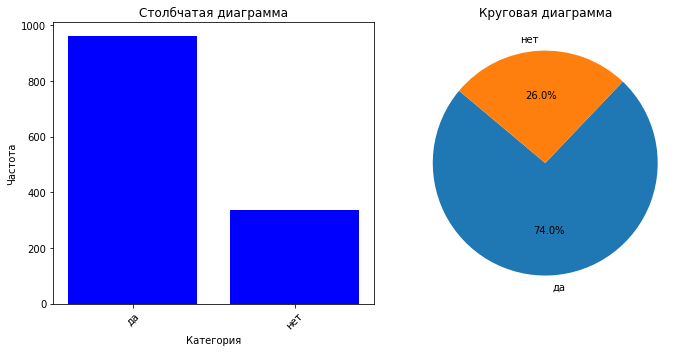

----------------------------------------------------------------------------------------------------
Популярная_категория


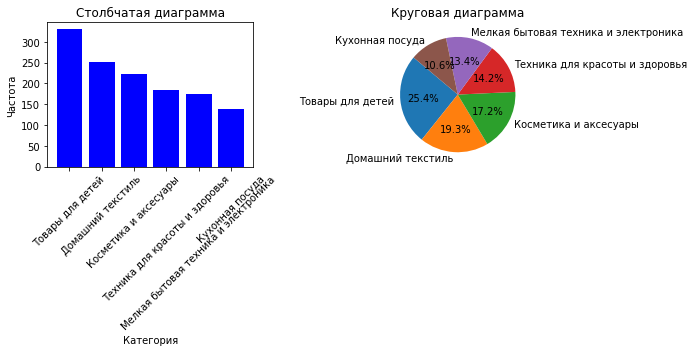

----------------------------------------------------------------------------------------------------


In [26]:
columns = ['Покупательская активность', 
           'Тип сервиса', 
           'Разрешить сообщать', 
           'Популярная_категория']
for column in columns:
    print(column)
    cat_plots(market_file[column])
    print('-'*100)

построим гистограмму и ящик с усами для числовых признаков таблицы *market_money*

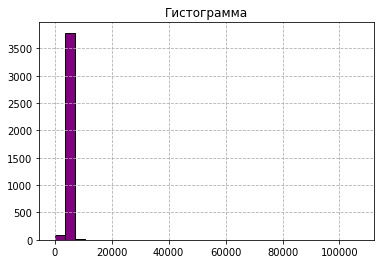

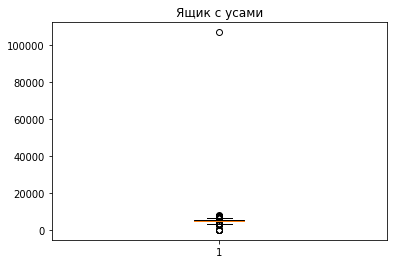

Описательная статистика
count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64
--------------------------------------------------


In [27]:
hist_plot(market_money['Выручка'])

избавимся от аномального значения 106862.2, определив айди и удалив все данные с с ним

In [28]:
print(market_money[market_money['Выручка']>100000])

        id         Период   Выручка
98  215380  текущий_месяц  106862.2


In [29]:
market_money = market_money[market_money['id']!=215380]

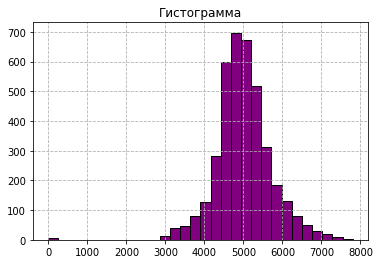

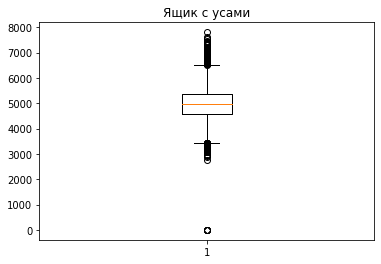

Описательная статистика
count    3897.000000
mean     4999.287760
std       706.970089
min         0.000000
25%      4590.000000
50%      4956.000000
75%      5363.000000
max      7799.400000
Name: Выручка, dtype: float64
--------------------------------------------------


In [30]:
hist_plot(market_money['Выручка'])

распределение - нормальное

Построим графики для категориального признака

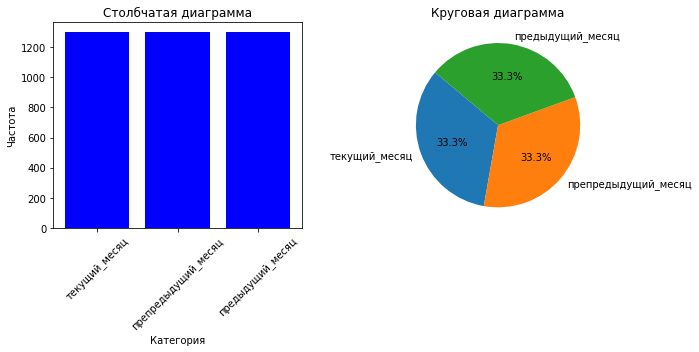

In [31]:
cat_plots(market_money['Период'])

построим гистограмму и ящик с усами для числовых признаков таблицы *market_time*

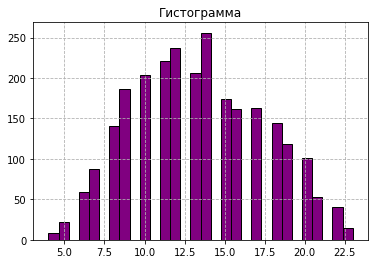

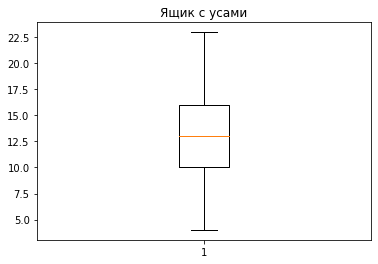

Описательная статистика
count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64
--------------------------------------------------


In [32]:
hist_plot(market_time['минут'])

распределение - нормальное, построим графики для категориального признака

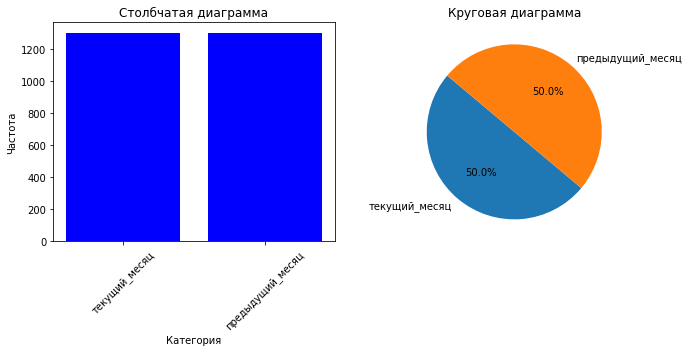

In [33]:
cat_plots(market_time['Период'])

построим гистограмму и ящик с усами для числовых признаков таблицы money

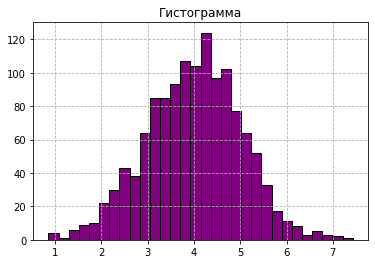

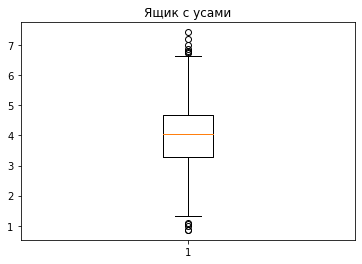

Описательная статистика
count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64
--------------------------------------------------


In [34]:
hist_plot(money['Прибыль'])

Распределение - нормальное

теперь найдем список покупателей с активностью менее 3 месяцев и удалим их из датасета

In [35]:
market_money['id'].nunique()

1299

In [36]:
del_id = (market_money[market_money['Выручка']==0])['id'].unique()
print(del_id)

[215348 215357 215359]


In [37]:
market_money = market_money[~market_money['id'].isin(del_id)]
market_money['id'].nunique()

1296

таким образом, исследовательский анализ завершен, избавились от аномального значения и покупателей с активностью менее трех месяцев в таблице market_money, осталось всего 1296 пользователей

# 4. Объединение таблиц

Объединим все три таблицы кроме money, используем сводные таблицы для того что б разбить значения на разных периодах

In [38]:
market_money.head()

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4


In [39]:
pivot_df = market_money.pivot_table(index='id', columns='Период', values='Выручка', aggfunc='first')
pivot_df.reset_index(inplace=True)
columns_to_rename = {'предыдущий_месяц': 'выручка_за_предыдущий_месяц', 
                     'препредыдущий_месяц': 'выручка_за_препредыдущий_месяц', 
                     'текущий_месяц': 'выручка_за_текущий_месяц'}
pivot_df.rename(columns=columns_to_rename, inplace=True)
pivot_df.head()

Период,id,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


In [40]:
pivot_df2 = market_time.pivot_table(index='id', columns='Период', values='минут', aggfunc='first')
pivot_df2.reset_index(inplace=True)
columns_to_rename = {'предыдущий_месяц': 'минут_предыдущий_месяц', 
                     'текущий_месяц': 'минут_текущий_месяц'}
pivot_df2.rename(columns=columns_to_rename, inplace=True)
pivot_df2.head()

Период,id,минут_предыдущий_месяц,минут_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [41]:
merged_df=(market_file
           .merge(pivot_df, on='id')
           .merge(pivot_df2, on='id'))
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [42]:
merged_df.shape

(1296, 18)

Размерность объединённого датафрейма:
1296 строк,
18 столбцов

# 5. Корреляционный анализ

Будем использовать *phik* для подсчета корреляции между категориальными и числовыми признаками

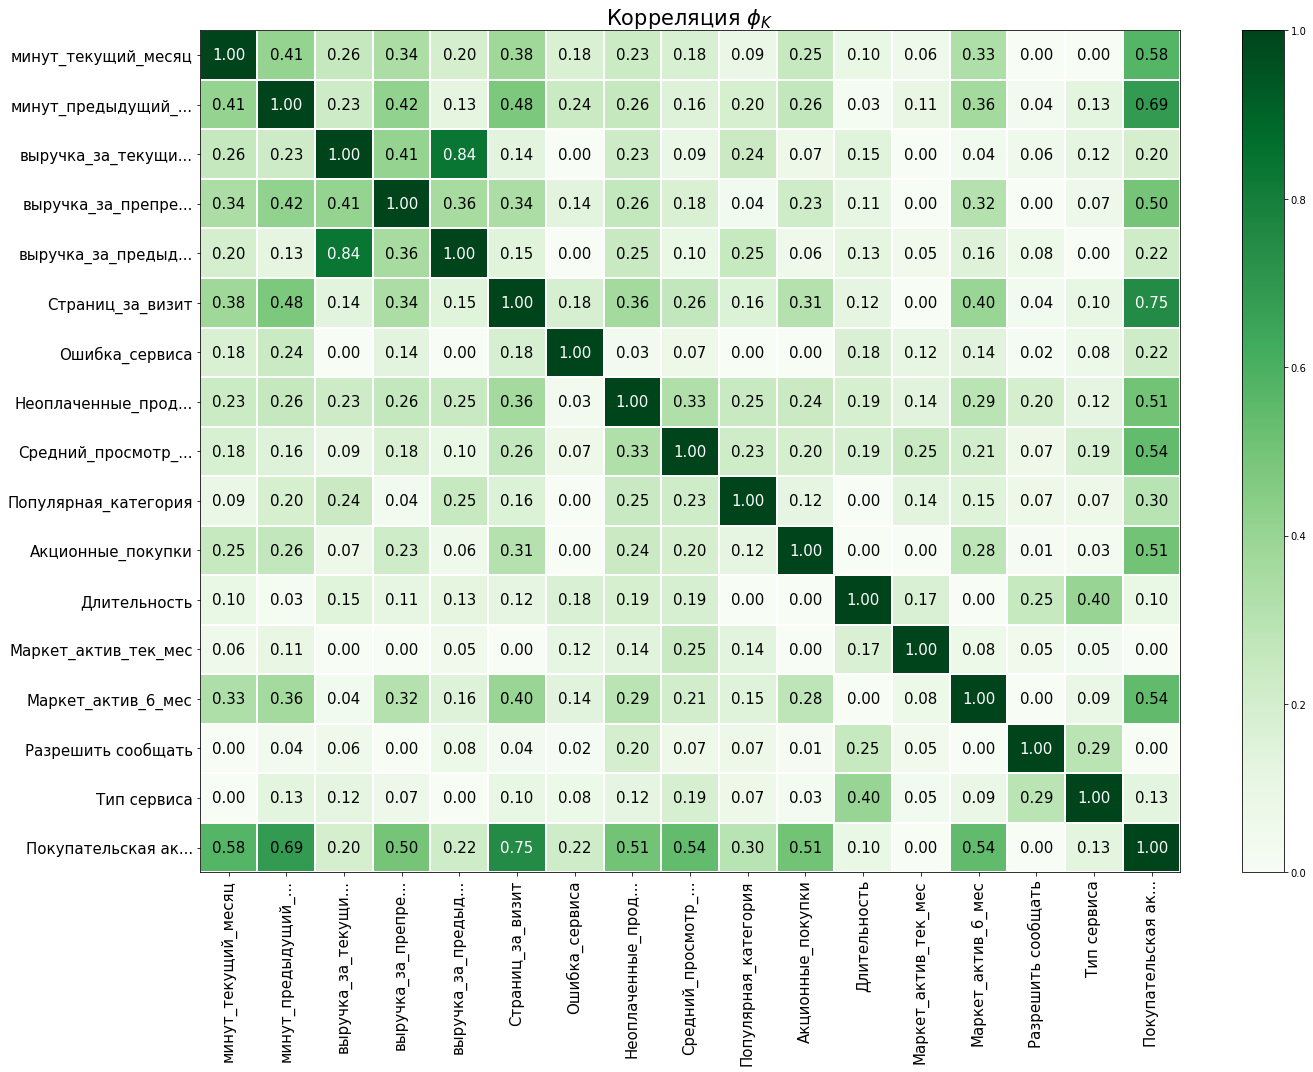

In [43]:
phik_overview = (
    merged_df
    .drop('id', axis=1)
    .phik_matrix(verbose=False))

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

по матрице корреляций можно сказать, что целевой признак - покупательская активность, а мультиколлинеарность отсутсвует

определим важные признаки и признаки которые практически не коррелируют с целевым признаком

In [44]:
phik_overview['Покупательская активность'].sort_values(ascending=False).tail(16)

Страниц_за_визит                       0.749888
минут_предыдущий_месяц                 0.685138
минут_текущий_месяц                    0.576770
Маркет_актив_6_мес                     0.544831
Средний_просмотр_категорий_за_визит    0.539607
Акционные_покупки                      0.506276
Неоплаченные_продукты_штук_квартал     0.505655
выручка_за_препредыдущий_месяц         0.497393
Популярная_категория                   0.299717
выручка_за_предыдущий_месяц            0.224638
Ошибка_сервиса                         0.224154
выручка_за_текущий_месяц               0.197213
Тип сервиса                            0.129940
Длительность                           0.099901
Маркет_актив_тек_мес                   0.000000
Разрешить сообщать                     0.000000
Name: Покупательская активность, dtype: float64

# 6. Использование пайплайнов

Для начала проверим целевой признак на дисбаланс классов

In [45]:
merged_df['Покупательская активность'].replace('Прежний уровень', 0, inplace=True)
merged_df['Покупательская активность'].replace('Снизилась', 1, inplace=True)

заменили значения Снизилась - 1, Прежний уровень - 0

Text(0, 0.5, 'Частота')

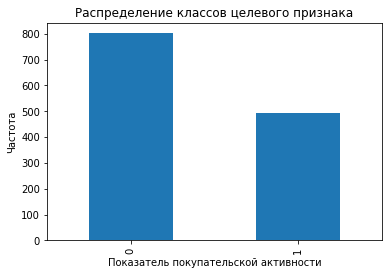

In [46]:
merged_df['Покупательская активность'].value_counts().plot(kind='bar')
plt.title('Распределение классов целевого признака')
plt.xlabel('Показатель покупательской активности')
plt.ylabel('Частота')

По графику видно, что имеется дисбаланс классов, поэтому при создании выборок будем использовать стратификацию.

In [47]:
RANDOM_STATE=42

X = merged_df.drop(columns=['Покупательская активность', 'id'])
y = merged_df['Покупательская активность']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=RANDOM_STATE, 
                                                    test_size=0.25, 
                                                    stratify=y)

Теперь, проверим, сохранился ли дисбаланс классов на тестовой и тренировочной выборке

Text(0, 0.5, 'Частота')

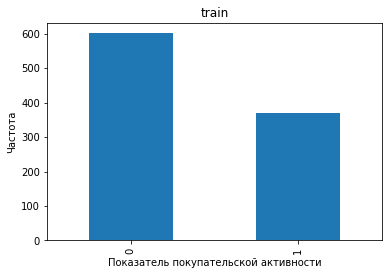

In [48]:
y_train.value_counts().plot(kind='bar')
plt.title('train')
plt.xlabel('Показатель покупательской активности')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

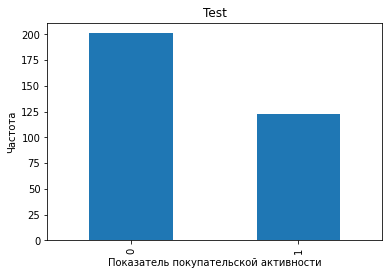

In [49]:
y_test.value_counts().plot(kind='bar')
plt.title('Test')
plt.xlabel('Показатель покупательской активности')
plt.ylabel('Частота')

как мы видим, разделение данных прошло успешно, приступим теперь к созданию пайплайна, будем использовать следующие модели:

KNeighborsClassifier()

DecisionTreeClassifier()

LogisticRegression()

SVC()

Выбираем метрику ROC-AUC, потому что она лучше всего подойдёт для задачи бинарной классификации с несбалансированным целевым признаком.

In [50]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [51]:
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип сервиса', 'Разрешить сообщать']
num_columns =  ['Маркет_актив_6_мес', 
               'Маркет_актив_тек_мес', 
               'Длительность', 
               'Акционные_покупки', 
               'Средний_просмотр_категорий_за_визит', 
               'Неоплаченные_продукты_штук_квартал', 
               'Ошибка_сервиса', 
               'Страниц_за_визит', 
               'выручка_за_текущий_месяц', 
               'выручка_за_предыдущий_месяц', 
               'выручка_за_препредыдущий_месяц', 
               'минут_текущий_месяц', 
               'минут_предыдущий_месяц']

ohe_pipe = Pipeline([('ohe', OneHotEncoder(drop='first', handle_unknown='error'))])

ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(
    categories=[
        ['стандарт', 'премиум'], 
        ['да', 'нет']], 
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan))])

Создадим пайплайн для подготовки данных

In [52]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)], 
    remainder='passthrough'
)

Сделаем итогоговый пайплайн

In [81]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
        {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 7),
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    }
    
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_iter=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print(f'Параметры лучшей модели:\n{randomized_search.best_params_}')
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке:', (randomized_search.best_score_))
probabilities_test = randomized_search.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
roc_auc_test = roc_auc_score(y_test, probabilities_one_test)
print('Метрика ROC-AUC на тестовой выборке с учетом вероятностей:', roc_auc_test)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['да',
                                                                                               'нет']],
                  

Вывод: после построения пайплайна, использовав 4 модели DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression(), SVC(), лучшей оказалась модель SVC() со следующими параметрами:

SVC(kernel='rbf')

с силой 2

и скалером MinMaxScaler()

Метрика ROC_auc на трэйне: 0.898

Метрика ROC_auc на тесте: 0.891

# 7. Анализ важности признаков

подготовим данные и обучим модель, для дальнейшего анализа важности признаков.

кодируем категориальные признаки с OneHotEncoder

In [54]:
ohe_encoder = OneHotEncoder(sparse=False, drop='first')
X_train_ohe = ohe_encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = ohe_encoder.transform(X_test[ohe_columns])
ohe_encoder_col_names = ohe_encoder.get_feature_names()

кодируем категориальные признаки с OrdinalEncoder

In [55]:
ord_encoder = OrdinalEncoder(
    categories=[
        ['стандарт', 'премиум'], 
        ['да', 'нет']], 
    handle_unknown='use_encoded_value', 
    unknown_value=np.nan)
X_train_ord = ord_encoder.fit_transform(X_train[ord_columns])
X_test_ord = ord_encoder.transform(X_test[ord_columns])
categories = ord_encoder.categories_
ord_encoder_col_names = [f"{col}" for col, category in zip(ord_columns, categories)]

масштабируем количественные признаки с помощью MinMaxScaler

In [56]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

Теперь объединим все данные в один датасет

In [57]:
# создаём тренировочный и тестовый датафреймы из закодированных и масштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe_encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe_encoder_col_names)

X_train_ord = pd.DataFrame(X_train_ord, columns=ord_encoder_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=ord_encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

# объединим все преобразованные данные в тренировочный и тестовый датафреймы
X_train_ohe_ord = pd.concat([X_train_ohe, X_train_ord], axis=1)
X_train_final = pd.concat([X_train_ohe_ord, X_train_scaled], axis=1)

X_test_ohe_ord = pd.concat([X_test_ohe, X_test_ord], axis=1)
X_test_final = pd.concat([X_test_ohe_ord, X_test_scaled], axis=1)

In [58]:
X_train_final.shape

(972, 20)

In [59]:
X_test_final.shape

(324, 20)

In [60]:
y_train.shape

(972,)

In [61]:
y_test.shape

(324,)

Теперь обучим модель SVC(kernel='rbf'), с силой 2

In [62]:
model = SVC(kernel='rbf', C=2, random_state=RANDOM_STATE, probability=True)
model.fit(X_train_final, y_train)
y_pred = model.predict(X_test_final)
print('Метрика ROC_AUC на тренировочной:', round(cross_val_score(model, X_train_final, y_train, scoring='roc_auc').mean(), 3))
print(f'Метрика ROC_AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred), 3)}')

Метрика ROC_AUC на тренировочной: 0.898
Метрика ROC_AUC на тестовой выборке: 0.888


построим график важности признаков с помощью метода SHAP. 

  0%|          | 0/25 [00:00<?, ?it/s]

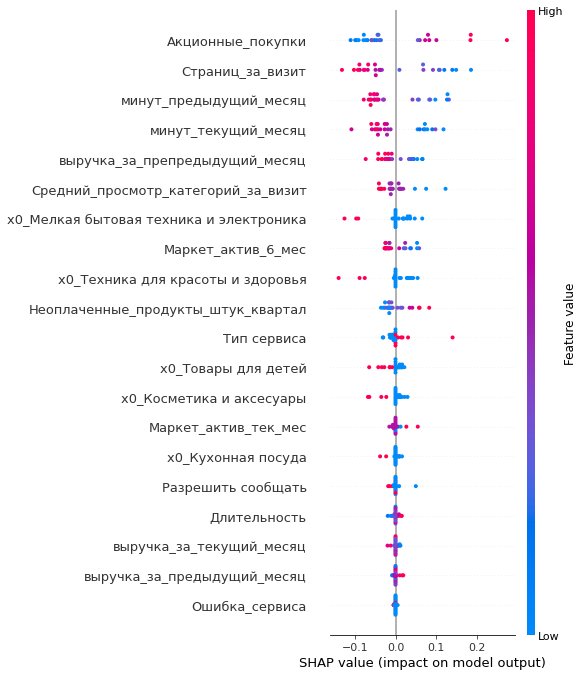

In [63]:
X_train_background = shap.kmeans (X_train_final, 25)
explainer = shap.KernelExplainer(model.predict, X_train_background.data)
shap_values = explainer.shap_values(X_train_background.data)
shap.summary_plot(shap_values, X_train_background.data, feature_names=X_train_final.columns.tolist())

**Вывод:**
самыми важными оказались следующие признаки:
1. Страниц_за_визит
2. Акционные покупки
3. минут_предыдущий_месяц
4. минут_текущий_месяц
5. выручка_за_препредыыдущий_месяц

самыми малозначимыми оказались следующие признаки:
1. Ошибка_сервиса
2. выручка_за_текущий_месяц
3. длительность
4. выручка_за_предыдущий_месяц
5. Разрешить сообщать

при моделировании и принятии бизнес-решений следует учесть, что:
1. На покупаетелей большое внимание оказывает наличие акционных предложений
2. Чем дольше пользователь находится на сайте, тем больше вероятность что он совершит покупку

# 8. Сегментация покупателей

Добавим в датасет merged_df столбцы вероятность_снижения_активности и предсказанная_активность

In [64]:
df_merged_ohe = ohe_encoder.transform(merged_df[ohe_columns])

df_merged_scaled = scaler.transform(merged_df[num_columns])

df_merged_ord = ord_encoder.transform(merged_df[ord_columns])


df_merged_ohe = pd.DataFrame(df_merged_ohe, columns=ohe_encoder_col_names)

df_merged_ord = pd.DataFrame(df_merged_ord, columns=ord_encoder_col_names)

df_merged_scaled = pd.DataFrame(df_merged_scaled, columns=num_columns)


df_merged_ohe_ord = pd.concat([df_merged_ohe, df_merged_ord], axis=1)
df_merged_final = pd.concat([df_merged_ohe_ord, df_merged_scaled], axis=1)

In [65]:
predictions = model.predict(df_merged_final)
probas = model.predict_proba(df_merged_final)[:,1]

In [66]:
merged_df['предсказанная_активность'] = predictions
merged_df['вероятность_снижения_активности'] = probas

In [67]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,предсказанная_активность,вероятность_снижения_активности
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,1,0.945210
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,1,0.753042
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,1,0.867562
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,1,0.937878
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,1,0.879371


теперь объединим этот датасет с таблицеей money, добавив столбец с прибылью

In [68]:
merged_df = merged_df.merge(money, on='id')

In [69]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,предсказанная_активность,вероятность_снижения_активности,Прибыль
0,215349,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,5216.0,4472.0,4971.6,12,10,1,0.945210,4.16
1,215350,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,5457.5,4826.0,5058.4,8,13,1,0.753042,3.13
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11,13,1,0.867562,4.87
3,215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,5807.5,4594.0,5872.5,8,11,1,0.937878,4.21
4,215353,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,4738.5,5124.0,5388.5,10,10,1,0.879371,3.95


перейдем к выбору сегмента для анализа, будем использовать признаки с высокой прибыльностью(>4.5) и высокой вероятностью снижения активности (>70%) 

In [70]:
segment = merged_df[(merged_df['Прибыль'] > 4.5) & (merged_df['вероятность_снижения_активности'] > 0.7)]
segment['id'].count()

120

Всего получилось 120 покупателей выбранного сегмента

In [71]:
segment

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,...,Ошибка_сервиса,Страниц_за_визит,выручка_за_предыдущий_месяц,выручка_за_препредыдущий_месяц,выручка_за_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,предсказанная_активность,вероятность_снижения_активности,Прибыль
2,215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,6158.0,4793.0,6610.4,11,13,1,0.867562,4.87
7,215356,1,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,...,1,3,4146.5,4433.0,4566.4,6,7,1,0.959033,4.93
9,215360,1,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,...,4,7,5304.5,5555.0,5834.9,9,6,1,0.887165,4.55
17,215368,1,премиум,да,3.8,5,829,0.24,Техника для красоты и здоровья,2,...,6,1,5823.0,4536.0,5591.6,11,9,1,0.917090,6.27
32,215384,1,стандарт,да,4.0,4,1020,0.34,Косметика и аксесуары,2,...,8,3,3584.0,4226.0,4010.4,11,12,1,0.772059,4.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,215910,1,стандарт,нет,3.9,3,509,0.95,Косметика и аксесуары,2,...,4,5,5360.0,4874.0,5911.2,11,17,1,0.952287,4.61
575,215927,1,стандарт,да,5.2,4,801,0.99,Кухонная посуда,2,...,4,9,5108.0,4798.0,4968.9,17,9,1,0.843499,5.35
579,215931,1,стандарт,нет,4.9,4,302,0.19,Кухонная посуда,1,...,3,7,5665.0,5263.0,6143.4,11,9,1,0.723482,5.33
1081,216433,0,стандарт,нет,4.0,3,788,0.23,Товары для детей,2,...,4,7,4752.0,4884.0,4996.4,9,5,1,0.736159,5.03


Определим количество покупателей, которые разрешили сообщать об акциях и построим график

In [72]:
segment['Разрешить сообщать'].value_counts()

да     89
нет    31
Name: Разрешить сообщать, dtype: int64

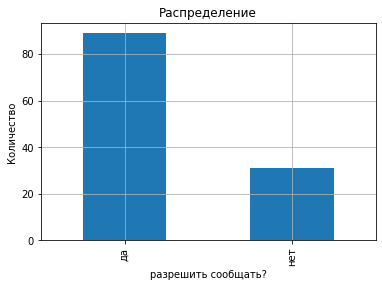

In [73]:
segment['Разрешить сообщать'].value_counts().plot.bar(grid=True)
plt.xlabel('разрешить сообщать?')
plt.ylabel('Количество')
plt.title('Распределение')
plt.show()

89 пользоватлей готовы получать рассылку с акциями и т. д.

Рассмотрим как часто покупатели оформляют премиум подписку на сервис

In [74]:
segment['Тип сервиса'].value_counts()

стандарт    73
премиум     47
Name: Тип сервиса, dtype: int64

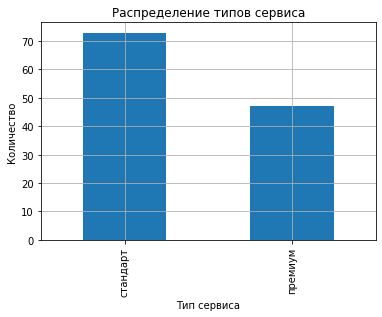

In [75]:
segment['Тип сервиса'].value_counts().plot.bar(grid=True)
plt.xlabel('Тип сервиса')
plt.ylabel('Количество')
plt.title('Распределение типов сервиса')
plt.show()

73 пользователя не используют подписку, таким образом, можно предложить им пробную подписку на месяц, что б повысить активность покупателей. А пользоватлей с подпиской премиум 47, можно предложить им скидку на последующую оплату подписки, повысив таким образом их активность.

Рассмотрим столбец популярная категория

In [76]:
segment['Популярная_категория'].value_counts()

Товары для детей                        38
Косметика и аксесуары                   31
Домашний текстиль                       21
Кухонная посуда                         15
Техника для красоты и здоровья          10
Мелкая бытовая техника и электроника     5
Name: Популярная_категория, dtype: int64

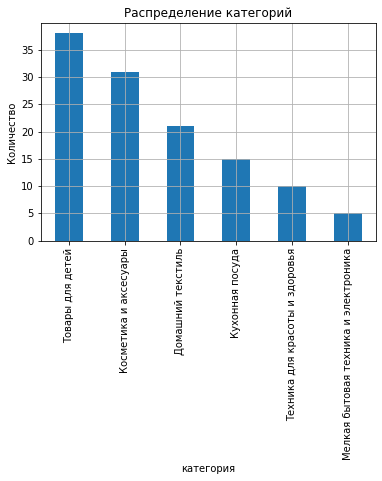

In [77]:
segment['Популярная_категория'].value_counts().plot.bar(grid=True)
plt.xlabel('категория')
plt.ylabel('Количество')
plt.title('Распределение категорий')
plt.show()

Можно разослать скидочные купоны, на те товары, которыми чаще интересуется покупатель

Построим гистограмму для столбца акционные покупки

<AxesSubplot:>

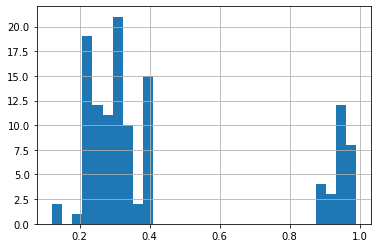

In [78]:
segment['Акционные_покупки'].hist(bins=30)

количество покупателей с акционными покупками более чем 80%:

In [79]:
segment['id'][segment['Акционные_покупки']>0.8].count()

27

27 пользователей можно привлечь с помощью персональных акций, можно также посмотреть какие категории они просматривают чаще всего, что бы как можно точнее персонализировать акции

**Вывод:**
Был отобран сегмент из 120 пользователей, с вероятностью снижения активности более 70 процентов и прибылью более 4,5.
для повышения активности можно сделать следующее:

1. 73 пользователя не используют подписку, таким образом, можно предложить им пробную подписку на месяц, что б повысить активность покупателей. А пользоватлей с подпиской премиум 47, можно предложить им скидку на последующую оплату подписки, повысив таким образом их активность.

2. Можно разослать скидочные купоны, на те товары, которыми чаще интересуется покупатель

3. 27 пользователей можно привлечь с помощью персональных акций, можно также посмотреть какие категории они просматривают чаще всего, что бы как можно точнее персонализировать акции

#  9. Общий вывод

Была выполнена задача по построению модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. Используя данные модели и данные о прибыльности клиентов, выделили сегмент покупателей и разработали для них персонализированные предложения.
В исходных данных было 4 таблицы:
1. market_file.csv - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
2. market_money.csv - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
3. market_time.csv - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
4. money.csv - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
напишите, что вы сделали для поиска лучшей модели;
укажите лучшую модель;
добавьте выводы и дополнительные предложения для выбранного сегмента покупателей

Для поиска лучшей модели мы использовали пайплан, который выбирал из 4 моделей:

KNeighborsClassifier()

DecisionTreeClassifier()

LogisticRegression()

SVC()

Лучшей из них, оказалась модель SVC() со следующими параметрами:

SVC(kernel='rbf')

с силой 2

и скалером MinMaxScaler()

Метрика ROC_auc на трэйне: 0.898

Метрика ROC_auc на тесте: 0.891

С помощью этой модели узнали вероятность принадлежности каждокого покупателя к классу - снижение активности и выделили сегмент из 120 пользователей с вероятностью снижения активности более 70% и прибылью более 4,5.
